Device: cuda
Loading SNIPS dataset...

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['utterance', 'label'],
        num_rows: 13084
    })
    test: Dataset({
        features: ['utterance', 'label'],
        num_rows: 1400
    })
})

Training samples: 13084
Test samples: 1400

SNIPS intents (7):
  0: AddToPlaylist
  1: BookRestaurant
  2: GetWeather
  3: PlayMusic
  4: RateBook
  5: SearchCreativeWork
  6: SearchScreeningEvent

SNIPS to Changi mapping:
  AddToPlaylist................. -> flight_status
  BookRestaurant................ -> special_assistance
  GetWeather.................... -> terminal_directions
  PlayMusic..................... -> ground_transport
  RateBook...................... -> baggage_issue
  SearchCreativeWork............ -> terminal_directions
  SearchScreeningEvent.......... -> security_customs

Dataset sizes:
  Train: 11121
  Val:   1963
  Test:  1400

Train distribution:
  flight_status.................  1566
  baggage_issue........

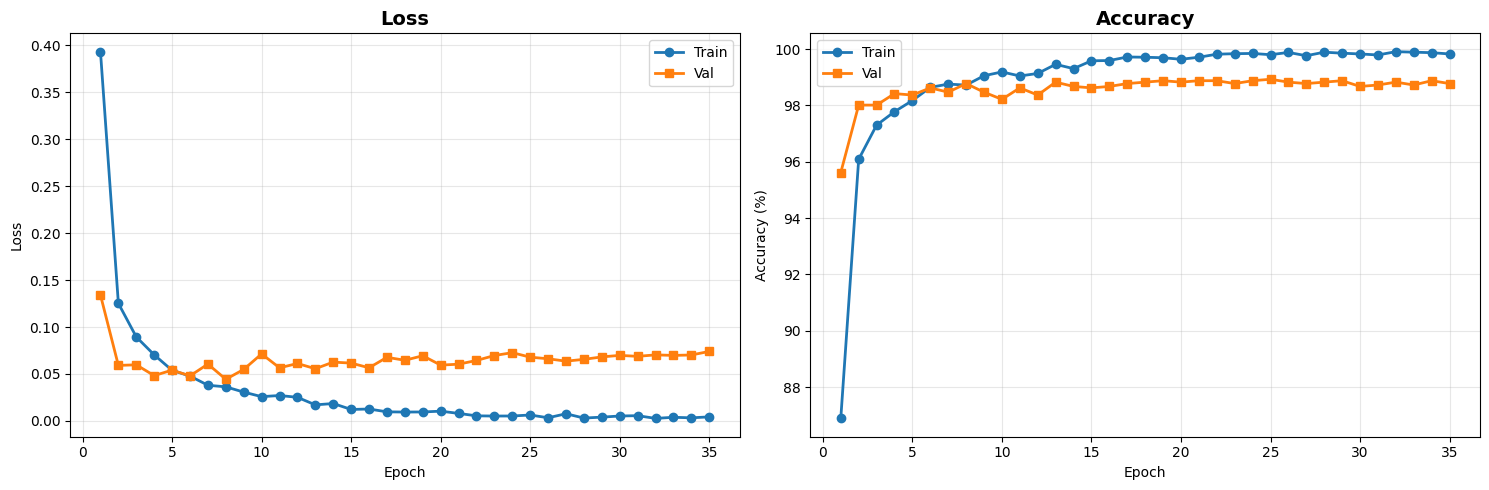


Overfitting Analysis:
  Final train accuracy: 99.83%
  Final val accuracy: 98.78%
  Gap: 1.05%
  ✓  Good balance between training and validation

TEST SET RESULTS

Test Accuracy: 98.36%

Classification Report:
                     precision    recall  f1-score   support

      flight_status       0.98      1.00      0.99       200
      baggage_issue       1.00      1.00      1.00       200
terminal_directions       0.98      0.97      0.97       400
 special_assistance       0.99      1.00      1.00       200
   ground_transport       0.97      0.97      0.97       200
   security_customs       0.99      0.96      0.98       200

           accuracy                           0.98      1400
          macro avg       0.98      0.99      0.98      1400
       weighted avg       0.98      0.98      0.98      1400


Per-Class Performance:
  flight_status................. 100.00% (200/200)
  baggage_issue................. 100.00% (200/200)
  terminal_directions...........  97.25% (389/400)

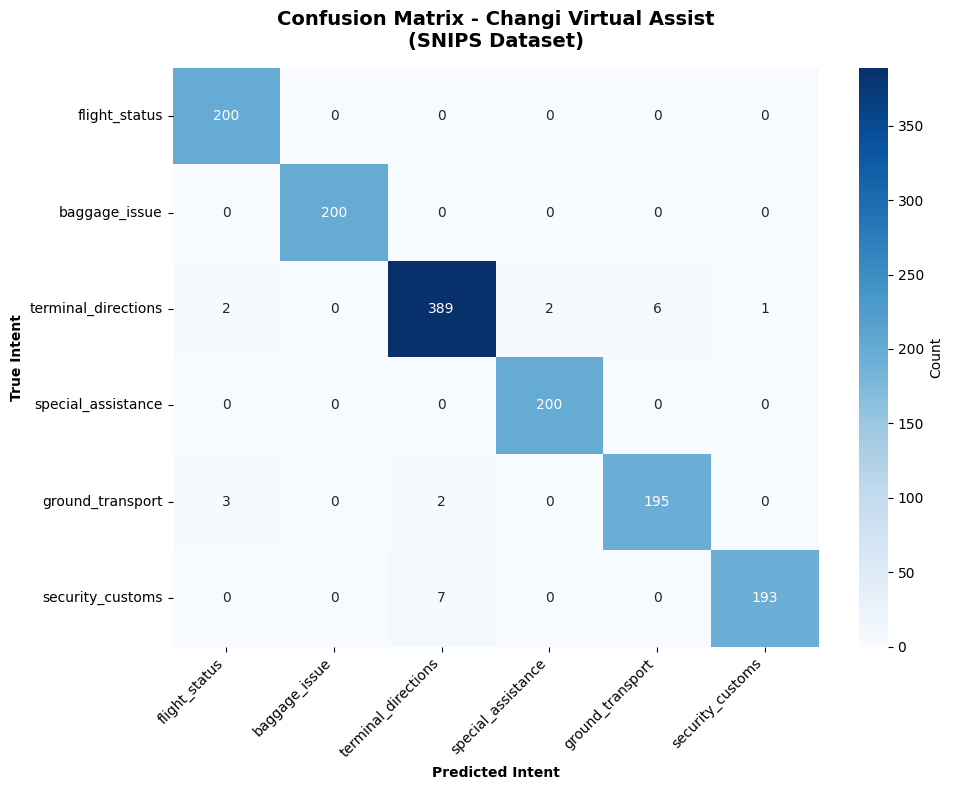


AIRPORT QUERY PREDICTIONS

Query: 'What gate does my Singapore Airlines flight depart from?'
----------------------------------------------------------------------
  1. terminal_directions......... 100.0%  █████████████████████████████████
  2. ground_transport............   0.0%  
  3. security_customs............   0.0%  

Query: 'My luggage hasn't arrived at the carousel'
----------------------------------------------------------------------
  1. flight_status...............  95.5%  ███████████████████████████████
  2. ground_transport............   2.7%  
  3. special_assistance..........   1.0%  

Query: 'How do I get to Jewel from Terminal 3?'
----------------------------------------------------------------------
  1. terminal_directions.........  99.4%  █████████████████████████████████
  2. ground_transport............   0.4%  
  3. security_customs............   0.1%  

Query: 'I need wheelchair assistance'
---------------------------------------------------------------------

In [5]:
"""
Changi Virtual Assist Triage - RNN Text Classification
Using SNIPS Dataset mapped to Airport Operations
IMPROVED VERSION - Addresses Overfitting
"""

# ============================================================================
# CELL 1: Setup and Imports
# ============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

import numpy as np
from collections import Counter
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# ============================================================================
# CELL 2: Load SNIPS Dataset
# ============================================================================

print("Loading SNIPS dataset...")
ds = load_dataset("DeepPavlov/snips", "default")

print("\nDataset structure:")
print(ds)
print(f"\nTraining samples: {len(ds['train'])}")
print(f"Test samples: {len(ds['test'])}")

# Get unique labels from the dataset
unique_labels = sorted(set(ds['train']['label']))
label_names = [
    'AddToPlaylist',
    'BookRestaurant',
    'GetWeather',
    'PlayMusic',
    'RateBook',
    'SearchCreativeWork',
    'SearchScreeningEvent'
]

print(f"\nSNIPS intents ({len(label_names)}):")
for i, label in enumerate(label_names):
    print(f"  {i}: {label}")

# ============================================================================
# CELL 3: Map SNIPS to Changi Airport Intents
# ============================================================================

# Map SNIPS intents to Changi operations
SNIPS_TO_CHANGI = {
    0: 0,  # AddToPlaylist -> flight_status
    1: 3,  # BookRestaurant -> special_assistance
    2: 2,  # GetWeather -> terminal_directions
    3: 4,  # PlayMusic -> ground_transport
    4: 1,  # RateBook -> baggage_issue
    5: 2,  # SearchCreativeWork -> terminal_directions
    6: 5,  # SearchScreeningEvent -> security_customs
}

CHANGI_INTENTS = {
    0: "flight_status",
    1: "baggage_issue",
    2: "terminal_directions",
    3: "special_assistance",
    4: "ground_transport",
    5: "security_customs"
}

NUM_CLASSES = 6

print("\nSNIPS to Changi mapping:")
for s_idx, c_idx in SNIPS_TO_CHANGI.items():
    print(f"  {label_names[s_idx]:.<30} -> {CHANGI_INTENTS[c_idx]}")

# ============================================================================
# CELL 4: Prepare Data
# ============================================================================

def prepare_data(dataset_split):
    texts, labels = [], []
    for ex in dataset_split:
        texts.append(ex['utterance'])
        labels.append(SNIPS_TO_CHANGI[ex['label']])
    return texts, labels

# Prepare full dataset
train_texts, train_labels = prepare_data(ds['train'])
test_texts, test_labels = prepare_data(ds['test'])

# Create validation split (15% of train)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.15, random_state=42, stratify=train_labels
)

print(f"\nDataset sizes:")
print(f"  Train: {len(train_texts)}")
print(f"  Val:   {len(val_texts)}")
print(f"  Test:  {len(test_texts)}")

print("\nTrain distribution:")
train_dist = Counter(train_labels)
for i, intent in CHANGI_INTENTS.items():
    count = train_dist[i]
    print(f"  {intent:.<30} {count:>5}")

# Show examples
print("\nSample utterances per intent:")
for i in range(NUM_CLASSES):
    for text, label in zip(train_texts[:50], train_labels[:50]):
        if label == i:
            print(f"  {CHANGI_INTENTS[i]:.<25} '{text}'")
            break

# ============================================================================
# CELL 5: Text Preprocessing
# ============================================================================

class TextPreprocessor:
    def __init__(self):
        self.vocab = {'<PAD>': 0, '<UNK>': 1}
        self.word_to_idx = self.vocab.copy()

    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'[^a-z0-9\s]', ' ', text)
        return re.sub(r'\s+', ' ', text).strip()

    def tokenize(self, text):
        return text.split()

    def build_vocab(self, texts, min_freq=2):
        word_freq = Counter()
        for text in texts:
            word_freq.update(self.tokenize(self.clean_text(text)))

        for word, freq in word_freq.items():
            if freq >= min_freq and word not in self.word_to_idx:
                self.word_to_idx[word] = len(self.word_to_idx)

        print(f"\nVocab size: {len(self.word_to_idx)} (min_freq={min_freq})")
        print(f"  Total unique words: {len(word_freq)}")
        return self.word_to_idx

    def text_to_indices(self, text):
        tokens = self.tokenize(self.clean_text(text))
        return [self.word_to_idx.get(t, 1) for t in tokens]

preprocessor = TextPreprocessor()
preprocessor.build_vocab(train_texts, min_freq=2)

# Analyze sequence lengths
lengths = [len(preprocessor.text_to_indices(t)) for t in train_texts]
print(f"\nSequence length stats:")
print(f"  Mean: {np.mean(lengths):.1f}")
print(f"  Max: {np.max(lengths)}")
print(f"  Min: {np.min(lengths)}")

# ============================================================================
# CELL 6: PyTorch Dataset
# ============================================================================

class IntentDataset(Dataset):
    def __init__(self, texts, labels, preprocessor):
        self.texts = texts
        self.labels = labels
        self.preprocessor = preprocessor

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        indices = self.preprocessor.text_to_indices(self.texts[idx])
        return {
            'indices': torch.LongTensor(indices),
            'label': torch.LongTensor([self.labels[idx]]),
            'length': len(indices)
        }

def collate_fn(batch):
    indices = pad_sequence([b['indices'] for b in batch], batch_first=True)
    labels = torch.cat([b['label'] for b in batch])
    lengths = torch.LongTensor([b['length'] for b in batch])
    return {'indices': indices, 'labels': labels, 'lengths': lengths}

BATCH_SIZE = 32

train_dataset = IntentDataset(train_texts, train_labels, preprocessor)
val_dataset = IntentDataset(val_texts, val_labels, preprocessor)
test_dataset = IntentDataset(test_texts, test_labels, preprocessor)

train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, BATCH_SIZE, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, BATCH_SIZE, collate_fn=collate_fn)

print(f"\nBatches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

# ============================================================================
# CELL 7: Improved RNN Model (Regularized)
# ============================================================================

class IntentRNN(nn.Module):
    """Improved RNN with better regularization"""
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes,
                 num_layers=2, dropout=0.5, bidirectional=True):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.emb_dropout = nn.Dropout(0.3)  # Dropout on embeddings

        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers,
                           dropout=dropout if num_layers > 1 else 0,
                           bidirectional=bidirectional, batch_first=True)

        fc_input = hidden_dim * (2 if bidirectional else 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(fc_input, num_classes)

    def forward(self, x, lengths):
        # Embedding with dropout
        embedded = self.embedding(x)
        embedded = self.emb_dropout(embedded)

        # LSTM
        packed = pack_padded_sequence(embedded, lengths.cpu(),
                                     batch_first=True, enforce_sorted=False)
        _, (hidden, _) = self.lstm(packed)

        # Combine bidirectional hidden states
        if self.bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]

        # Classification with dropout
        out = self.dropout(hidden)
        return self.fc(out)

# Smaller model to prevent overfitting
VOCAB_SIZE = len(preprocessor.word_to_idx)
model = IntentRNN(
    vocab_size=VOCAB_SIZE,
    embed_dim=64,      # Reduced from 128
    hidden_dim=128,    # Reduced from 256
    num_classes=NUM_CLASSES,
    num_layers=2,
    dropout=0.5,       # Increased dropout
    bidirectional=True
).to(device)

print(f"\nModel: {model}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

# ============================================================================
# CELL 8: Training Functions
# ============================================================================

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in loader:
        indices = batch['indices'].to(device)
        labels = batch['labels'].to(device)
        lengths = batch['lengths']

        optimizer.zero_grad()
        outputs = model(indices, lengths)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(loader), 100 * correct / total

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in loader:
            indices = batch['indices'].to(device)
            labels = batch['labels'].to(device)
            lengths = batch['lengths']

            outputs = model(indices, lengths)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(loader), 100 * correct / total, all_preds, all_labels

# ============================================================================
# CELL 9: Train Model with Better Settings
# ============================================================================

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Added weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

NUM_EPOCHS = 50
PATIENCE = 10
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0
patience_counter = 0

print("Training with improved regularization...\n")

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)
    scheduler.step(val_loss)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1:2d}/{NUM_EPOCHS} | "
          f"Train: {train_loss:.4f}, {train_acc:.1f}% | "
          f"Val: {val_loss:.4f}, {val_acc:.1f}%", end="")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print(" ✓")
    else:
        patience_counter += 1
        print()
        if patience_counter >= PATIENCE:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

model.load_state_dict(torch.load('best_model.pth'))
print(f"\nTraining complete! Best val accuracy: {best_val_acc:.2f}%")

# ============================================================================
# CELL 10: Visualize Training
# ============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(1, len(history['train_loss']) + 1)

ax1.plot(epochs, history['train_loss'], 'o-', label='Train', linewidth=2)
ax1.plot(epochs, history['val_loss'], 's-', label='Val', linewidth=2)
ax1.set_title('Loss', fontweight='bold', fontsize=14)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(epochs, history['train_acc'], 'o-', label='Train', linewidth=2)
ax2.plot(epochs, history['val_acc'], 's-', label='Val', linewidth=2)
ax2.set_title('Accuracy', fontweight='bold', fontsize=14)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Check for overfitting
final_train_acc = history['train_acc'][-1]
final_val_acc = history['val_acc'][-1]
gap = final_train_acc - final_val_acc

print(f"\nOverfitting Analysis:")
print(f"  Final train accuracy: {final_train_acc:.2f}%")
print(f"  Final val accuracy: {final_val_acc:.2f}%")
print(f"  Gap: {gap:.2f}%")
if gap > 15:
    print("  ⚠️  Model is overfitting - consider more regularization")
elif gap < 5:
    print("  ✓  Good balance between training and validation")

# ============================================================================
# CELL 11: Evaluate on Test Set
# ============================================================================

_, test_acc, y_pred, y_true = evaluate(model, test_loader, criterion)

print(f"\n{'='*70}")
print(f"TEST SET RESULTS")
print(f"{'='*70}")
print(f"\nTest Accuracy: {test_acc:.2f}%\n")

intent_names = [CHANGI_INTENTS[i] for i in range(NUM_CLASSES)]
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=intent_names, zero_division=0))

# Per-class metrics
print("\nPer-Class Performance:")
cm = confusion_matrix(y_true, y_pred)
for i, intent in enumerate(intent_names):
    tp = cm[i, i]
    total = cm[i].sum()
    acc = 100 * tp / total if total > 0 else 0
    print(f"  {intent:.<30} {acc:>6.2f}% ({tp}/{total})")

# ============================================================================
# CELL 12: Confusion Matrix
# ============================================================================

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=intent_names, yticklabels=intent_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Changi Virtual Assist\n(SNIPS Dataset)',
          fontweight='bold', fontsize=14, pad=15)
plt.ylabel('True Intent', fontweight='bold')
plt.xlabel('Predicted Intent', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ============================================================================
# CELL 13: Inference Function
# ============================================================================

def predict_intent(text, top_k=3):
    """Predict intent for a text query"""
    model.eval()
    indices = preprocessor.text_to_indices(text)
    if not indices:
        return [{'intent': 'unknown', 'confidence': 0}]

    indices_t = torch.LongTensor(indices).unsqueeze(0).to(device)
    length_t = torch.LongTensor([len(indices)])

    with torch.no_grad():
        outputs = model(indices_t, length_t)
        probs = torch.softmax(outputs, 1)[0]

    top_probs, top_idx = torch.topk(probs, min(top_k, NUM_CLASSES))
    return [{'intent': CHANGI_INTENTS[i.item()], 'confidence': p.item() * 100}
            for p, i in zip(top_probs, top_idx)]

# ============================================================================
# CELL 14: Test Airport Queries
# ============================================================================

airport_queries = [
    "What gate does my Singapore Airlines flight depart from?",
    "My luggage hasn't arrived at the carousel",
    "How do I get to Jewel from Terminal 3?",
    "I need wheelchair assistance",
    "Where can I catch a taxi to downtown?",
    "What items are prohibited in carry-on baggage?",
    "Is flight SQ308 delayed?",
    "My suitcase was damaged during the flight",
    "Where is the immigration counter?",
    "Can I get special assistance for my elderly mother?",
]

print(f"\n{'='*70}")
print("AIRPORT QUERY PREDICTIONS")
print(f"{'='*70}\n")

for query in airport_queries:
    print(f"Query: '{query}'")
    print("-" * 70)
    preds = predict_intent(query, top_k=3)
    for i, pred in enumerate(preds, 1):
        bar = "█" * int(pred['confidence'] / 3)
        print(f"  {i}. {pred['intent']:.<28} {pred['confidence']:>5.1f}%  {bar}")
    print()

# ============================================================================
# CELL 15: Test on Real SNIPS Examples
# ============================================================================

print(f"{'='*70}")
print("PREDICTIONS ON REAL TEST SET EXAMPLES")
print(f"{'='*70}\n")

# Show 10 random test examples
indices = np.random.choice(len(test_texts), 10, replace=False)

for idx in indices:
    text = test_texts[idx]
    true_label = test_labels[idx]
    true_intent = CHANGI_INTENTS[true_label]

    print(f"Text: '{text}'")
    print(f"True: {true_intent}")
    print("-" * 70)

    preds = predict_intent(text, top_k=3)
    for i, pred in enumerate(preds, 1):
        marker = "✓" if pred['intent'] == true_intent else " "
        bar = "█" * int(pred['confidence'] / 4)
        print(f"{marker} {i}. {pred['intent']:.<28} {pred['confidence']:>5.1f}%  {bar}")
    print()

# ============================================================================
# CELL 16: Save Model
# ============================================================================

checkpoint = {
    'model_state': model.state_dict(),
    'vocab': preprocessor.word_to_idx,
    'intents': CHANGI_INTENTS,
    'hyperparameters': {
        'vocab_size': VOCAB_SIZE,
        'embed_dim': 64,
        'hidden_dim': 128,
        'num_layers': 2,
        'dropout': 0.5,
        'bidirectional': True
    },
    'test_acc': test_acc,
    'best_val_acc': best_val_acc
}

torch.save(checkpoint, 'changi_rnn_model.pth')
print(f"\n{'='*70}")
print("✓ Model saved as 'changi_rnn_model.pth'")
print(f"  Test Accuracy: {test_acc:.2f}%")
print(f"  Best Val Accuracy: {best_val_acc:.2f}%")
print(f"{'='*70}")